**We start the analysis with the "ordini-mepa" dataset, which contains aggregate numbers for all administration issuing direct order on the Mepa platform for the analyzed year.**

**Goal: We want to provide an assistance tool to the PA to understand what would be a fair price to pay for a given good or service, based on historical data.
On the other hand, this tool could also be used as to identify outliers in the data and therefore trigger control on the purchase behavior of a given PA. A PO would insert the asset to buy, and our model should return a reference price point for it. Such a tool can be help to allow a more conscious and data-driven approach to the purchase decisions of the PA.**

**Problem definition: The dataset contains geographical information regarding the PA and the company issuing the service/good, plus a description of the good or service that is issued, together with the economical value. The main idea is to exploit the description of the product to create a predictor of the final unit size order prince in euros. Particularly, we want to exploit that similar products will result in similar price points. This (reasonable) assumption should help the model make better price predictions. To do so, we will transform the textual descriptions of the good or service into a numerical vector using a pre-trained embedding model (word2vec), and then train a model to predict the final unit order price in euros. Using a word embedding model allows us to correlate products that are similar to each other (which should help producing a more accurate price estimation). This type of approaches have been used in solving cold-start pricing issues for new products, and for cold-start product recommandations. Let's see if it works at all in this case.**

In [ ]:
##List of dependencies
##gensim
##nltk (https://stackoverflow.com/questions/41348621/ssl-error-downloading-nltk-data)
##nltk.download('popular')
##pattern
##enchant

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pattern.it import singularize
import matplotlib.pyplot as plt

import enchant
it_dic = enchant.Dict('it_IT')
import pyphen
hyphen_dic = pyphen.Pyphen(lang = 'it_IT')

##Load word2vec model (pre-trained) http://hlt.isti.cnr.it/wordembeddings/
from gensim.models import Word2Vec
emb_model = Word2Vec.load('./word2vec/wiki_iter=5_algorithm=skipgram_window=10_size=300_neg-samples=10.m')

In [2]:
##Import the data
orders = pd.read_csv('./dataset/7.acquisti/ordini-mepa-2019.csv', decimal = ',')
##Some basic cleanup of the numberical values
orders['Valore_economico_Ordini'] = orders['Valore_economico_Ordini'].astype('float').fillna(0.0)
orders['N_Ordini'] = orders['N_Ordini'].astype('float').fillna(0.0)
non_zero_orders = (orders['Valore_economico_Ordini'] > 0.0) & (orders['Valore_economico_Ordini'] > 0.0)
orders = orders[non_zero_orders]
orders.head()

#Anno_Riferimento                          Tipologia_Amministrazione  \
0               2019  AZIENDE OSPEDALIERE, POLICLINICI, IRCCS e ISTI...   
1               2019  AZIENDE OSPEDALIERE, POLICLINICI, IRCCS e ISTI...   
2               2019  AZIENDE OSPEDALIERE, POLICLINICI, IRCCS e ISTI...   
3               2019  AZIENDE OSPEDALIERE, POLICLINICI, IRCCS e ISTI...   
4               2019  AZIENDE OSPEDALIERE, POLICLINICI, IRCCS e ISTI...   

  Regione_PA Provincia_PA Sigla_provincia_PA Regione_Fornitore Bando_Mepa  \
0   CAMPANIA       NAPOLI                NaN             LAZIO       BENI   
1   CAMPANIA       NAPOLI                NaN             LAZIO       BENI   
2   CAMPANIA       NAPOLI                NaN             LAZIO       BENI   
3   CAMPANIA       NAPOLI                NaN             LAZIO       BENI   
4   CAMPANIA       NAPOLI                NaN             LAZIO       BENI   

                              Categoria_Abilitazione  \
0                  FORNITURE SPECIFICHE PER LA SANIT   
1  INFORMATICA, ELETTRONICA, TELECOMUNICAZIONI E ...   
2                ATTREZZATURE E SEGNALETICA STRADALE   
3                ATTREZZATURE E SEGNALETICA STRADALE   
4                                             ARREDI   

                                       bene_servizio  codice_CPV  \
0               FIBROSCOPI FLESSIBILI PER ENDOSCOPIA  33168000-5   
1                                       SCHEDE MADRI  30237140-2   
2  SEGNALI STRADALI ORIZZONTALI E VERTICALI E ATT...  34928470-3   
3                              SEGNALI COMPLEMENTARI  34928470-3   
4          ELETTRODOMESTICI PER LA CASA E LA PERSONA  39710000-2   

                             descrizione_CPV  N_Ordini  \
0  APPARECCHI PER ENDOSCOPIA E ENDOCHIRURGIA       1.0   
1                               SCHEDE MADRI       1.0   
2                                SEGNALETICA       1.0   
3                                SEGNALETICA       1.0   
4                           ELETTRODOMESTICI       2.0   

   Valore_economico_Ordini  N_PA  N_fornitori  N_PO  
0                 13000.00     1            1     1  
1                    32.98     1            1     1  
2                   210.00     1            1     1  
3                   250.00     1            1     1  
4                  1230.60     2            2     2

**Let's start by giving a look at the amount of unique categories in "bene_servizio" and "descrizione_CPV"**

In [3]:
good_service = orders['bene_servizio']
description = orders['descrizione_CPV']
category = orders['Categoria_Abilitazione']
print("Unique 'Categoria_Abilitazione':", category.nunique())
print("Unique 'bene_servizio':", good_service.nunique())
print("Unique 'descrizione_CPV':", description.nunique())

Unique 'Categoria_Abilitazione': 33
Unique 'bene_servizio': 1304
Unique 'descrizione_CPV': 616


**'Categoria_Abilitazione' provides a very general description, so we are going to neglect it in the rest of the analysis. Let's print the percentage of entries in the dataset for each unique denomination, for both bene_servizio and descrizione_CPV**

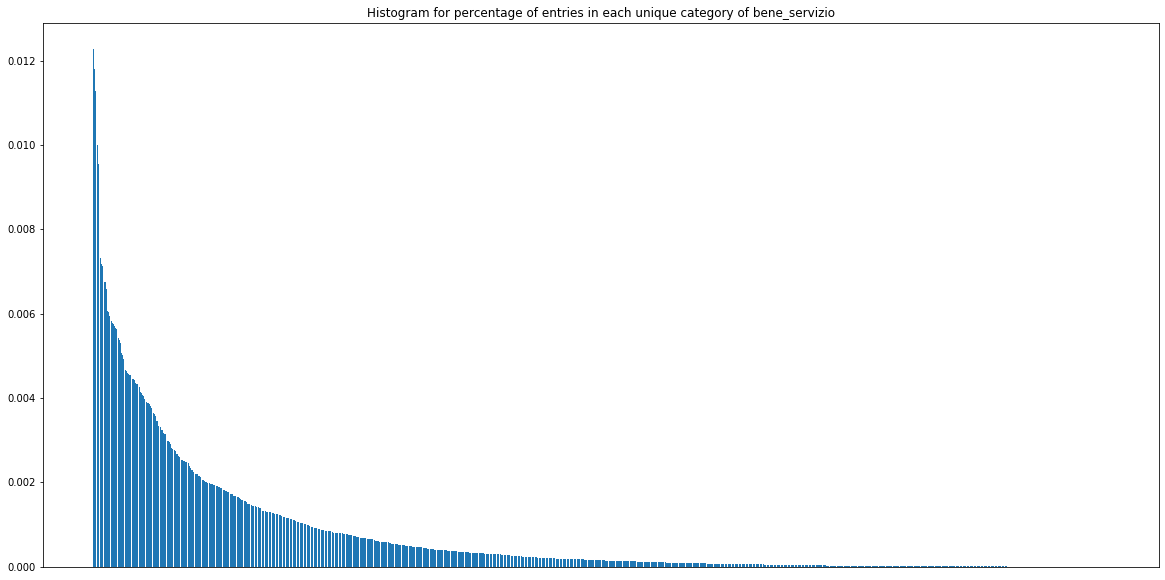

In [4]:
plt.figure(figsize = (20,10))
plt.bar(good_service.value_counts().index.tolist(), good_service.value_counts(normalize = True).values.tolist())
plt.gca().axes.xaxis.set_visible(False)
_ = plt.title('Histogram for percentage of entries in each unique category of bene_servizio')

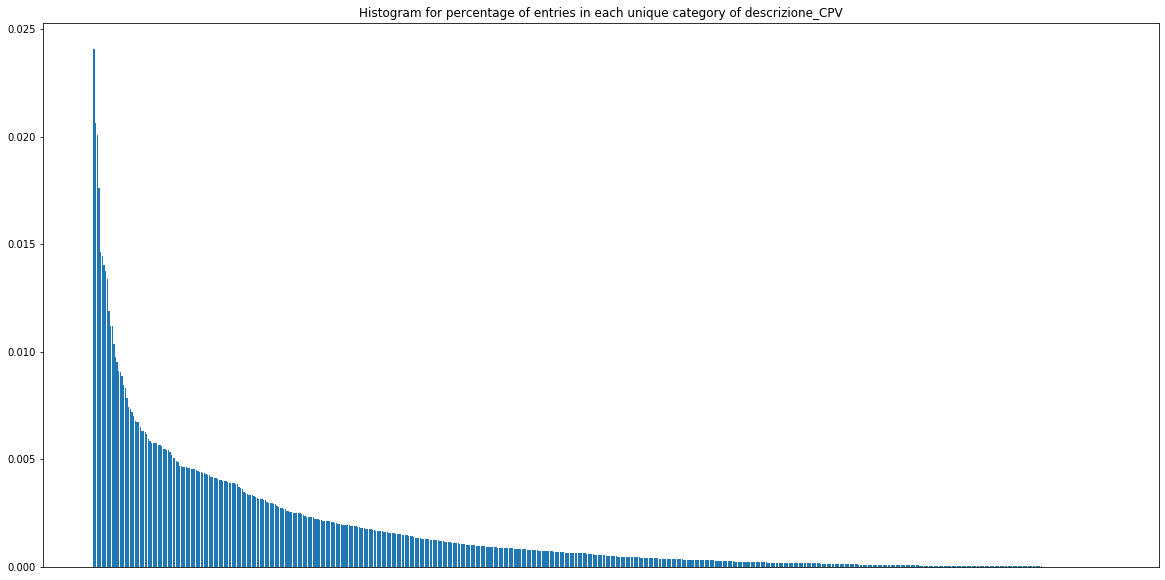

In [5]:
plt.figure(figsize = (20,10))
plt.bar(description.value_counts().index.tolist(), description.value_counts(normalize = True).values.tolist())
plt.gca().axes.xaxis.set_visible(False)
_ = plt.title('Histogram for percentage of entries in each unique category of descrizione_CPV')

**For both 'bene_servizio' and 'descrizione_CPV', we obtain pretty long-tail distributions. This tells us there is indeed a big variety of products being requested, and that exploiting products similarity for better price estimation could be worthwile. Out of curiosity, we can also print the 10 most requested categories**

In [6]:
print(good_service.value_counts().index.tolist()[0:10])

['CARTUCCE E TONER INK-LASER ORIGINALI', 'SOFTWARE DI GESTIONE', 'PERSONAL COMPUTER (ACQUISTO)', 'SERVIZI DI MANUTENZIONE SOFTWARE', 'CARTA BIANCA (80 G/M) IN RISME (500FF)', 'NOTEBOOK ELETTRONICI', 'MONITOR A COLORI', 'ACCESSORI PER ALIMENTAZIONE', 'FERRAMENTA', 'PENNA MONOUSO']


**We can note that "Personal computer" and "Notebook Elettronici" are indeed similar items even though they fall in different categories. Same for "Software di gestione" and "Servizi manutenzione software". We can also plot the unit price order distribution**

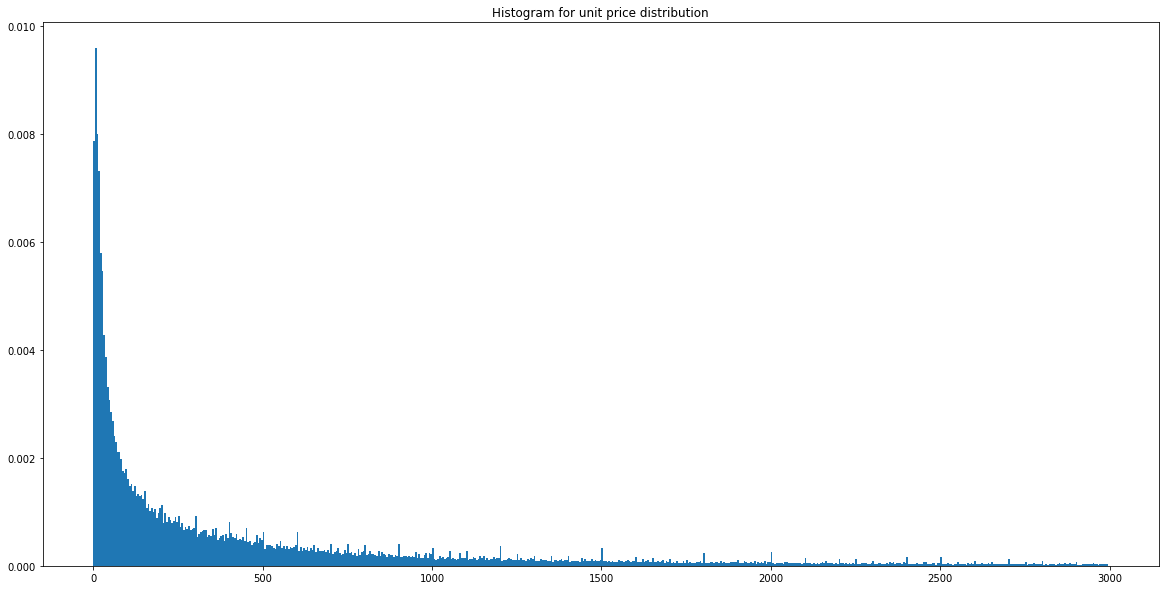

In [7]:
total_order_price = orders['Valore_economico_Ordini']
order_count = orders['N_Ordini']
unit_price = total_order_price/order_count
plt.figure(figsize = (20,10))
_ = plt.hist(unit_price, density = True, bins = np.arange(0, np.quantile(unit_price, 0.9), 5))
_ = plt.title('Histogram for unit price distribution')

In [8]:
print("Min unit price:", np.min(unit_price), "- Max:", np.max(unit_price), "- Median:", np.median(unit_price), "- Average:", np.average(unit_price), " - STD:", np.std(unit_price))

Min unit price: 0.01 - Max: 180000.0 - Median: 235.0 - Average: 1328.413160834298  - STD: 3872.0137972982875


**As for the categories, also the distribution of the unit price category has a long-tail, but there is a pretty big bulk of items below 200 euros that compose almost 50% of the total unit order prices.**

**We need to do some cleanup first. We are mainly interesting in "bene_servizio" and "descrizione_CPV". We need to remove stop words (e, per, articles etc.) and other symbols (lemma, dash, hyphens etc.)**

In [9]:
##We get italian stopwords
italian_sw = stopwords.words('italian')
italian_sw[0:10]
symbols = ["-", ",", "'", "(", ")", "/", ";"]

In [10]:
##Basic cleanup. Since the set of words is pretty constrained, something simple should be sufficient
def cleanup_sentence(sentence):
    final = sentence.lower()
    for s in symbols:
        final = final.replace(s, ' ')
    return final

##Cleanup, tokenize word and remove stop words
def token_and_remove(sentence):
    clean = cleanup_sentence(sentence)
    tokens = word_tokenize(clean)
    tokens_without_sw = [word for word in tokens if not word in italian_sw]
    return tokens_without_sw

In [11]:
##Tokenize word and remove stop words
good_service = good_service.apply(lambda sentence: token_and_remove(sentence))
print(good_service)

0                      [fibroscopi, flessibili, endoscopia]
1                                           [schede, madri]
2         [segnali, stradali, orizzontali, verticali, at...
3                                  [segnali, complementari]
4                         [elettrodomestici, casa, persona]
                                ...                        
201019    [accessori, videocamere, fotocamere, lettori, ...
201020    [accessori, videocamere, fotocamere, lettori, ...
201021    [accessori, videocamere, fotocamere, lettori, ...
201022    [accessori, videocamere, fotocamere, lettori, ...
201023    [accessori, videocamere, fotocamere, lettori, ...
Name: bene_servizio, Length: 201018, dtype: object


In [12]:
##Tokenize word and remove stop words
description = description.apply(lambda sentence: token_and_remove(sentence))
print(description)

0         [apparecchi, endoscopia, endochirurgia]
1                                 [schede, madri]
2                                   [segnaletica]
3                                   [segnaletica]
4                              [elettrodomestici]
                           ...                   
201019      [parti, accessori, macchine, ufficio]
201020      [parti, accessori, macchine, ufficio]
201021      [parti, accessori, macchine, ufficio]
201022      [parti, accessori, macchine, ufficio]
201023      [parti, accessori, macchine, ufficio]
Name: descrizione_CPV, Length: 201018, dtype: object


**We now calculate the embedding for each entry in the dataset. We consider each entry as a "sentence" composed of different words. We use the word2vec model to calculate an embedding for each word, and then a simple approach (as described in "A simple but though-to-beat baseline for sentence embeddings") to calculate the embedding for each sentence/entry**

In [103]:
##Count the total number of occurrences in the word embedding
emb_size = emb_model.vector_size
tot_vw_count = 0.0
for vw in emb_model.wv.vocab:
    tot_vw_count += emb_model.wv.vocab[vw].count

In [14]:
##Given a list of words, produce the embedding for each word/sentence
##See 'filter_sentence': when we try to break up the words, we might end up in some weird combinations. Since the set of items is pretty constrained, we can safely introduce some domain-specific check to avoid getting unwanted words
unwanted_words = ['tori', 'tata', 'poli', 'flesso', 'auto', 'bili' 'vidi', 'cerchio', 'forti', 'sono']

##We polish the sentence to avoid duplicats and make sure it is in the vocabulary of the embedding
def filter_sentence(sentence):
    
    sentence = np.unique(sentence)
    sentence_filtered = []
    for s in sentence:
        if (len(s) > 2):
            ##If the word is present in the word embedding, we just use it as is
            if s in emb_model.wv:
                sentence_filtered.append(s)
            ##Certain words are not present in the word embedding, either because they are slightly technical ('xerografica'), singular/plural ('evidenziatorI'), grammatical errors ('paccheti'), composite words ('portalettere')
            else:
                ##We fix a grammatical error present in the dataset (pattern could help here, but in this case it's easier to fix this manually)
                if s == 'paccheti':
                    sentence_filtered.append('pacchetti')
                else:
                    ##We try to singularize the word
                    singular = singularize(s)
                    if singular in emb_model.wv:
                        sentence_filtered.append(singular)
                    else:
                        ##We try to break up the word and see if it's a composite. Third row verifies the words are in the Italian dictionary
                        for pair in hyphen_dic.iterate(s):
                            if pair[0] not in unwanted_words and pair[1] not in unwanted_words \
                            and len(pair[0]) > 2 and len(pair[1]) > 2 \
                            and it_dic.check(pair[0]) and it_dic.check(pair[1]):
                                ##If both exists in the embedding, we use it
                                if pair[0] in emb_model.wv and pair[1] in emb_model.wv:
                                    sentence_filtered.append(pair[0])
                                    sentence_filtered.append(pair[1])
                                    
    return sentence_filtered

##Re-implementation of "A simple but though-to-beat baseline for sentence embeddings". This is a simple approach that computes the sentence embedding
##by giving less weight to embeddings of word that have higher probability of occurring in the dictionary
def weighted_sentence_embedding(sentence, alpha = 1e-3):
    
    if (len(sentence) == 0):
        return []
    
    embedding = np.zeros((1, emb_size))
    for i in range(len(sentence)):
        vw = sentence[i]
        ##Probability of a certain word in the vocabulary
        prob_vw = emb_model.wv.vocab[vw].count/tot_vw_count
        embedding += emb_model[vw]*(alpha/(alpha + prob_vw))
        
    embedding /= len(sentence)
    return embedding
        

**Step 1 of sentence embedding calculation: compute the weighted embedding of all the words in the sentence**

In [15]:
##Combine all descriptions together in a single dataframe
combined = good_service + description
##Let's filter those words that are not in the word embedding model
combined_filtered = combined.apply(lambda sentence: filter_sentence(sentence))
combined_sent_emb = combined_filtered.apply(lambda sentence: weighted_sentence_embedding(sentence))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [16]:
assert(len(combined_sent_emb) == len(unit_price))

##We transform everything to numpy array for ease of use
combined_sent_emb_np = combined_sent_emb.to_numpy()
unit_price_np = unit_price.to_numpy()
combined_np = combined_filtered.to_numpy()

In [17]:
filtered_sentences = []
filtered_embeddings = []
filtered_prices = []
##We filter amongst all the datapoints for which we have an embedding
##TODO: This could be done better by recombining everything in the same dataframe and filtering the rows.
for i in range(len(combined_sent_emb_np)):
    
    ##If we have the embedding, we consider the entry
    if len(combined_sent_emb_np[i]) > 0:
        
        filtered_embeddings.append(combined_sent_emb_np[i][0])
        filtered_prices.append(unit_price_np[i])
        filtered_sentences.append(combined_np[i])

print("Among", len(combined_sent_emb), "datapoints,", len(combined_sent_emb) - len(filtered_embeddings), "were removed because we did not have the embeddings")

Among 201018 datapoints, 325 were removed because we did not have the embeddings


In [18]:
print(filtered_sentences[0])

['apparecchi', 'endo', 'chirurgia', 'endoscopia', 'flessibili']


In [19]:
assert(len(filtered_embeddings) == len(filtered_prices))
assert(len(filtered_embeddings) == len(filtered_sentences))

prices = np.array(filtered_prices)
prices = np.reshape(prices, (len(prices), 1))

sentences = np.array(filtered_sentences)
sentences = np.reshape(sentences, (len(sentences), 1))

embeddings = np.zeros((len(filtered_embeddings), emb_size))

for i in range(len(filtered_embeddings)):
    embeddings[i] = filtered_embeddings[i].astype('float')

print(prices.shape)
print(sentences.shape)
print(embeddings.shape)

(200693, 1)
(200693, 1)
(200693, 300)


**Step 2 of sentence embedding calculation: we remove the first singular principal component of the transpose of the matrix embedding (see "A simple but though-to-beat baseline for sentence embeddings")**

In [20]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 1, n_iter = 7, random_state = 11)
svd.fit(embeddings)
principal_component = np.array(svd.components_[0]).reshape(1, emb_size)

In [21]:
##Calculate the final embedding
embeddings = embeddings - embeddings.dot(principal_component.transpose()) * principal_component

**Let's try to give a visual look at the generated embeddings. We first reduce the number of components from 300 to 50. We need this to run t-sne to visualize the data (t-sne has scalability issues when applyed to high-dimensional spaces and/or the number of samples is very high -  we choose 50 as empirically suggested by scikit package for a reasonable upper bound for t-sne)**

In [22]:
from sklearn.decomposition import PCA

emb_pca = PCA(n_components = 50)
pca_embeddings = emb_pca.fit_transform(embeddings)

[0.09902261 0.0591037  0.05024938 0.03874085 0.02794029 0.0259528
 0.02533139 0.02446805 0.02247202 0.01918746 0.01885196 0.017288
 0.01643796 0.0156586  0.01532805 0.01456289 0.01407876 0.01335522
 0.01249087 0.01210739 0.01163121 0.01115591 0.01057956 0.00996408
 0.00979242 0.00960347 0.00919455 0.00869963 0.00854006 0.00830552
 0.00796378 0.00775263 0.00735276 0.00725091 0.00684952 0.00679723
 0.00661273 0.00645999 0.00625756 0.00615847 0.00586519 0.00574614
 0.00559227 0.00535271 0.00517958 0.0050618  0.0049534  0.00469024
 0.00461211 0.0045594 ]
Variance explained: 0.761163084076563


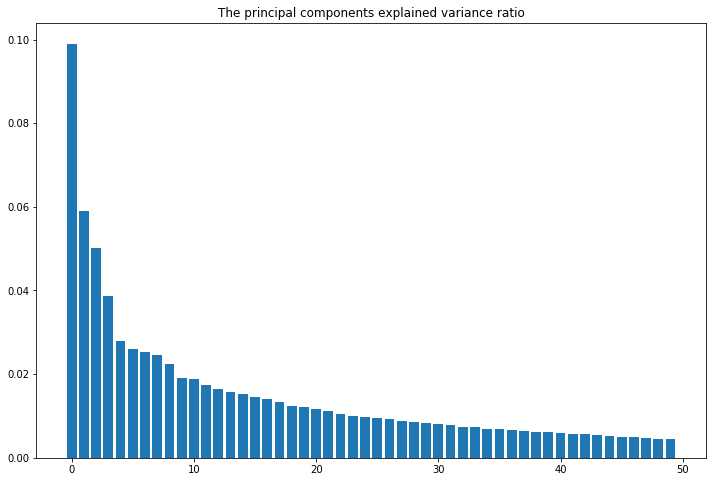

In [23]:
plt.figure(figsize = (12,8))
plt.bar(np.arange(0, len(emb_pca.explained_variance_ratio_)), emb_pca.explained_variance_ratio_)
_ = plt.title('The principal components explained variance ratio')
print(emb_pca.explained_variance_ratio_)
print("Variance explained:", np.sum(emb_pca.explained_variance_ratio_))

**As expected, there are a few components that can better explain the data. This means that the feature of the embeddings are correlated among each other. We are going to visualize the potential clusters using t-sne. We select a small random subset of the total dataset to speed up computation and still have an idea of the clusters. We settle for around 20% of the data in ordini-mepa 2019. We also check different levels of perpexlity (smaller values tends to create visualization that captures local variance in data; larger values instead allows to capture more global aspects of the data)**

In [25]:
from sklearn.manifold import TSNE
rand_index = np.random.choice(pca_embeddings.shape[0], 20000, replace = False)

In [26]:
emb_tsne_5 = TSNE(n_components = 2, perplexity = 5)
tsne_embeddings_5 = emb_tsne_5.fit_transform(pca_embeddings[rand_index])

In [27]:
emb_tsne_10 = TSNE(n_components = 2, perplexity = 10)
tsne_embeddings_10 = emb_tsne_10.fit_transform(pca_embeddings[rand_index])

In [28]:
emb_tsne_50 = TSNE(n_components = 2, perplexity = 50)
tsne_embeddings_50 = emb_tsne_50.fit_transform(pca_embeddings[rand_index])

In [29]:
emb_tsne_100 = TSNE(n_components = 2, perplexity = 100)
tsne_embeddings_100 = emb_tsne_100.fit_transform(pca_embeddings[rand_index])

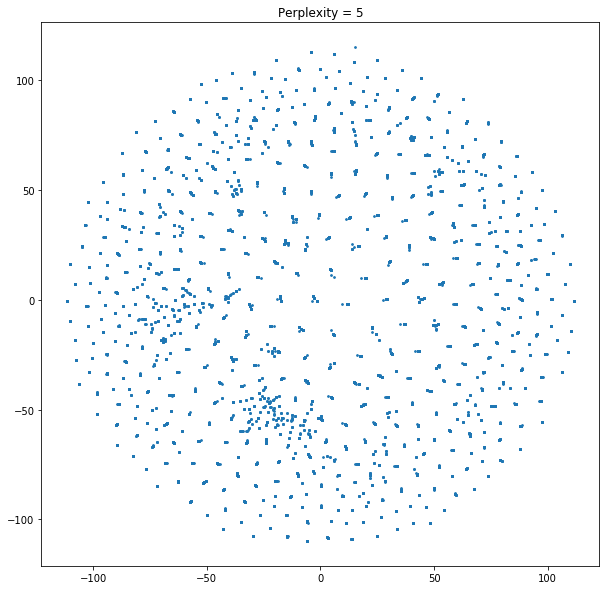

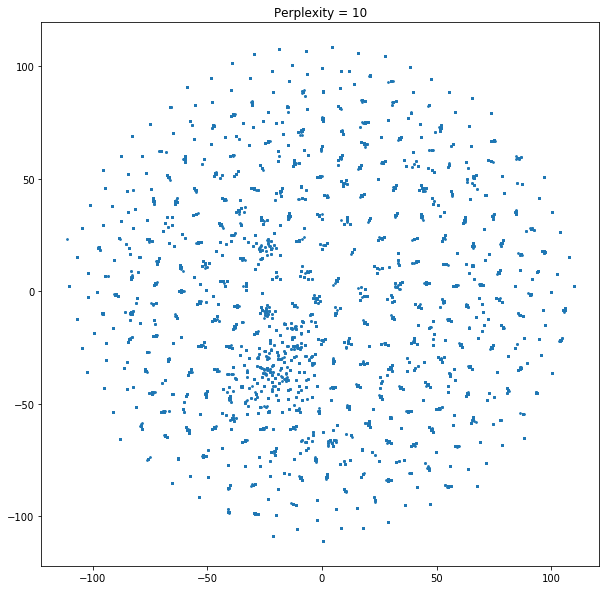

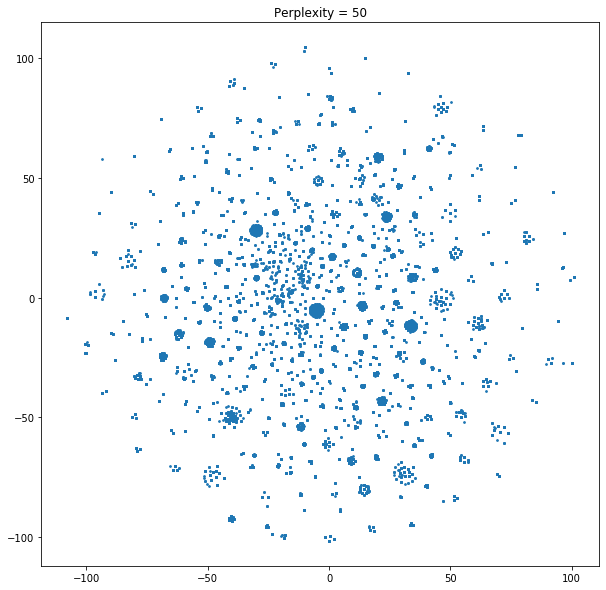

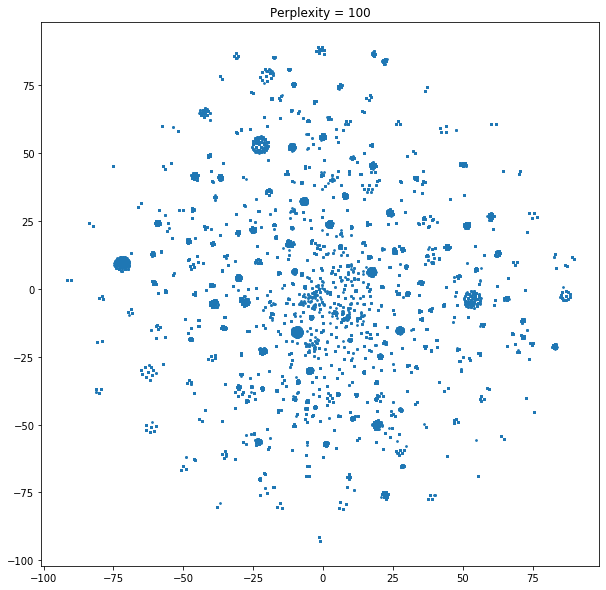

In [30]:
plt.figure(figsize = (10,10))
plt.scatter(tsne_embeddings_5[:,0], tsne_embeddings_5[:,1], s = 3)
_ = plt.title('Perplexity = 5')
plt.figure(figsize = (10,10))
plt.scatter(tsne_embeddings_10[:,0], tsne_embeddings_10[:,1], s = 3)
_ = plt.title('Perplexity = 10')
plt.figure(figsize = (10,10))
plt.scatter(tsne_embeddings_50[:,0], tsne_embeddings_50[:,1], s = 3)
_ = plt.title('Perplexity = 50')
plt.figure(figsize = (10,10))
plt.scatter(tsne_embeddings_100[:,0], tsne_embeddings_100[:,1], s = 3)
_ = plt.title('Perplexity = 100')

**As the perplexity value increases, we can notice how the clusters tend to be more "condensed". This is expected, and it shows that indeed there are clusters of objects with similar semantic meaning. Clusters appear also for lower values of perplexity, but they tend to be smaller. We can try to get an understanding of the "meaning" of these clusters, by using k-means. We are not interested in clustering per se, but more of a way to have a feeling on whether the embedding works or not**

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 50)
kmeans_clusters = kmeans.fit_predict(tsne_embeddings_50)

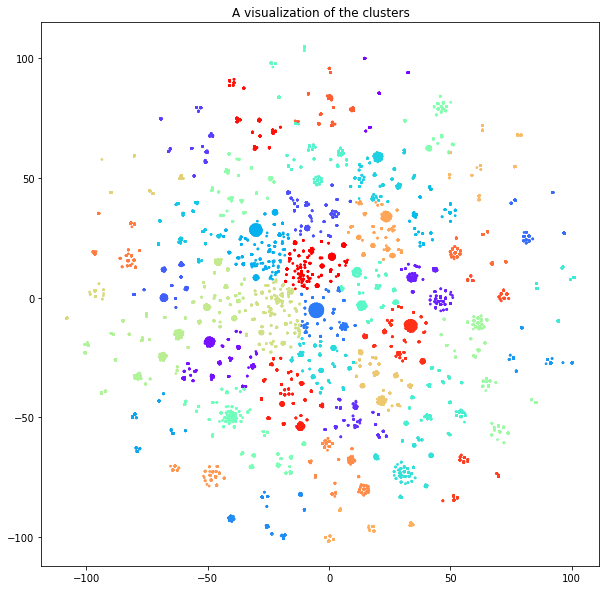

In [32]:
plt.figure(figsize = (10,10))
plt.scatter(tsne_embeddings_50[:,0], tsne_embeddings_50[:,1], s = 3, c = kmeans.labels_, cmap = 'rainbow')
_ = plt.title('A visualization of the clusters')

**It is possible to change the values of the clusters and re-evaluate. If we print the items in a specific cluster (see cell below), we can indeed find that there is a correlation between items in a cluster (or maybe group of items that are related to each other). There are also examples where this is not entirely true. This could depend on: (i) wrong number of clusters selected for k-means and (ii) k-means is a distance-based clustering algorithm and in the new 2-D space created by t-sne, a distance between two points might not be really representative of the actual distance of those two points in the 300-D (300 being the dimension of the original word embedding) space, which can negatively impact the clustering. But the results indicate that the embedding is producing something meaningful**

In [33]:
cluster_indexes = np.where(kmeans.labels_ == 0)
for i in range(0, 50):
    print(filtered_sentences[rand_index[cluster_indexes][i]])

['bagagli', 'borse', 'sacchi', 'selleria', 'valigie', 'zaini']
['buste', 'foratura', 'plastica', 'senza', 'universale']
['buste', 'foratura', 'plastica', 'senza', 'universale']
['bagagli', 'borse', 'sacchi', 'selleria', 'valigie', 'zaini']
['buste', 'foratura', 'plastica', 'senza', 'universale']
['guanti', 'monouso']
['buste', 'foratura', 'plastica', 'senza', 'universale']
['buste', 'foratura', 'plastica', 'senza', 'universale']
['generali', 'pacchetti', 'software']
['generali', 'pacchetti', 'software']
['buste', 'foratura', 'plastica', 'senza', 'universale']
['buste', 'foratura', 'plastica', 'senza', 'universale']
['generali', 'pacchetti', 'software']
['generali', 'pacchetti', 'software']
['bagagli', 'borse', 'sacchi', 'selleria', 'valigie', 'zaini']
['buste', 'foratura', 'plastica', 'senza', 'universale']
['guanti', 'monouso']
['guanti', 'monouso']
['buste', 'foratura', 'plastica', 'senza', 'universale']
['buste', 'foratura', 'plastica', 'senza', 'universale']
['guanti', 'monouso']
[

**Let's now work on the actual prediction model for the unit price. We will investigate the performance of several models. Given the way embeddings are defined (they are already scaled between -1 and 1), we do not need to do futher pre-processing of the data. In other cases, it might be necessary to scale the feature so that they have similar mean and standard deviation values. As we can see from the following, the mean and standard deviation of the different features are in the same order of magnitude**

In [104]:
print("Mean:", np.min(embeddings.mean(axis = 0)), np.max(embeddings.mean(axis = 0)))
print("STD:", np.min(embeddings.std(axis = 0)), np.max(embeddings.std(axis = 0)))

Mean: -0.011449107761542383 0.00950331515071416
STD: 0.10100377404775568 0.1664439048111347


**We take 10% of the total dataset for validation purposes**

In [35]:
from sklearn.model_selection import train_test_split

#X, X_val, y, y_val = train_test_split(embeddings, prices, test_size = 0.1, random_state = 11)
val_index = np.random.choice(embeddings.shape[0], int(0.1*len(embeddings)), replace = False)
train_index = [ind for ind in range(0, len(embeddings)) if ind not in val_index]

X = embeddings[train_index]
y = prices[train_index]
X_sent = sentences[train_index]

X_val = embeddings[val_index]
y_val = prices[val_index]
X_val_sent = sentences[val_index]

**As a simple baseline, we can compute the estimated price based on the unique entries in the dataset, as the average of the unit prices for each unique entry**

In [36]:
##We gather the unique categories in the dataset
unique_sentences, indices = np.unique(X_sent, return_inverse = True)

def compute_estimate_category(index):
    ##We get all the prices of the entries in a specific category, and compute the average
    category_prices = y[np.where(indices == index)]
    return np.average(category_prices)

##For each unique entry, let's compute the average price in that category and use it as an estimate
est_price = np.zeros((len(unique_sentences), 1))
for i in range(0, len(unique_sentences)):
    est_price[i] = compute_estimate_category(i)
    
##We can then predict the price based on these estimations
y_val_pred = np.zeros((len(X_val_sent), 1))
for i in range(0, len(X_val_sent)):
    est_price_val = est_price[np.where(unique_sentences == X_val_sent[i])]
    if (len(est_price_val) > 0):
        y_val_pred[i] = est_price_val

In [109]:
##We can now compute the performance based on the mean squared error
from sklearn.metrics import mean_squared_error

def rmse_validation(pred, real):
    non_zero_predictions = np.where(pred > 0)
    print("No entries for", len(pred) - len(non_zero_predictions[0]), "items")
    print("RMSE:", mean_squared_error(real[non_zero_predictions], pred[non_zero_predictions], squared = False))
    print()

In [110]:
print("Simple model based on average price per unique catego, for training and validation set")
rmse_validation(est_price, y)
rmse_validation(y_val_pred, y_val)

##What about using the average of the unit price in the training set?
print("Simple model based on average price in the training set, for training and validation set")
rmse_validation(np.average(y)*np.ones((len(y), 1)), y)
rmse_validation(np.average(y)*np.ones((len(y_val), 1)), y_val)

Simple model based on average price per unique catego, for training and validation set
No entries for 0 items
RMSE: 5503.703308273244

No entries for 16 items
RMSE: 3159.8991761292755

Simple model based on average price in the training set, for training and validation set
No entries for 0 items
RMSE: 3902.8817361213646

No entries for 0 items
RMSE: 3605.525639265698



**In both cases, results are pretty bad. Computing the average per class helps but the results are still far from something useful. Let's try to use the sentence embeddings instead. We will consider all the items for which the cosine similarity with respect to the item we want to predict is higher than a threshold (e.g., 0.95)**

In [41]:
##Calculate cosine similarity between two vectors
def compute_cos_similarity(vec1, vec2):
    a = np.dot(vec1.transpose(), vec2)
    b = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    return a/b

##Compute all the cosine similarities for a specific category wrt all the other entries in the dataset
##TODO: this code can be sped up consistently by only keeping the sentence embeddings for the unique entry and then map it to the index of the training set entries
def cos_similarities(sentence_index):
    sentence_embedding = X[np.where(indices == sentence_index)][0]
    return np.apply_along_axis(compute_cos_similarity, 1, X, sentence_embedding)

index_array = np.arange(len(unique_sentences)).reshape((len(unique_sentences), 1))
cosine_similarities = np.apply_along_axis(cos_similarities, 1, index_array)

**We can now estimate the price considering all the entries whose cosine similarity is higher than a threshold**

In [119]:
est_price_cosine = np.zeros((len(unique_sentences), 1))
for i in range(0, len(unique_sentences)):
    est_price_cosine[i] = np.average(y[np.where(cosine_similarities[i] >= 0.90)])
    
##We can then predict the price based on these estimations
y_val_pred_cosine = np.zeros((len(X_val_sent), 1))
for i in range(0, len(X_val_sent)):
    est_price_val = est_price_cosine[np.where(unique_sentences == X_val_sent[i])]
    if (len(est_price_val) > 0):
        y_val_pred_cosine[i] = est_price_val

In [120]:
print("Simple model based on cosine similarity, for training and validation set")
rmse_validation(est_price_cosine, y)
rmse_validation(y_val_pred_cosine, y_val)

Simple model based on cosine similarity, for training and validation set
No entries for 0 items
RMSE: 5406.516682902628

No entries for 16 items
RMSE: 3162.339374617243



**Results are unfortunately not better when using the embeddings. Changing the threshold has an impact, but the improvement is neglegible. Why is this happening? We can try to give a closer look at the embedding and related price distributions. Let's select a few examples that could help pinpoint the problem**

Item: ['abbassalingua', 'chirurgici', 'strumenti']
Number of unique entries in the dataset: 3
Number of entries with cosine similarity: 19
Similar items based on embeddings: [list(['abbassalingua', 'chirurgici', 'strumenti'])
 list(['chirurgiche', 'chirurgici', 'curette', 'strumenti'])
 list(['chirurgici', 'contrangoli', 'odontoiatrici', 'strumenti'])
 list(['chirurgici', 'divaricatori', 'strumenti'])
 list(['chirurgici', 'forcipi', 'strumenti'])
 list(['chirurgici', 'strumenti'])]
Average prices: 960.5
Std prices: 2344.888941596393

Item: ['acquisto', 'informatico', 'scanner', 'uso']
Number of unique entries in the dataset: 766
Number of entries with cosine similarity: 766
Similar items based on embeddings: [list(['acquisto', 'informatico', 'scanner', 'uso'])]
Average prices: 1211.5386201606054
Std prices: 2178.1896649084943

Item: ['ambulatoriale', 'corporea', 'digitali', 'lungo', 'periodo', 'registrazione', 'rilevazione', 'sistema', 'temperatura', 'termometri']
Number of unique entr

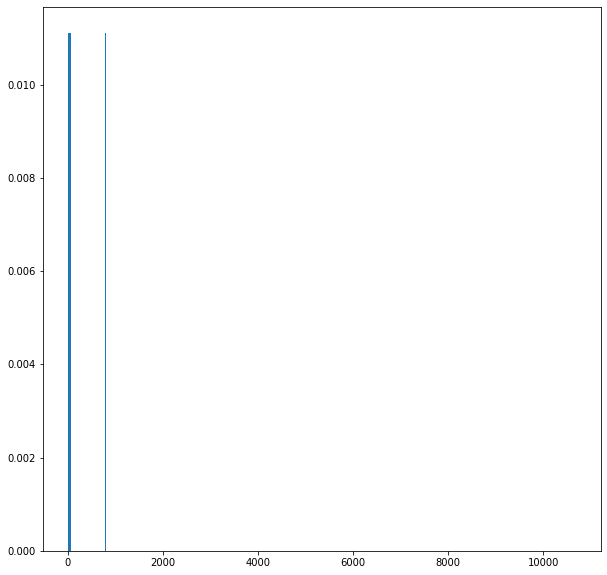

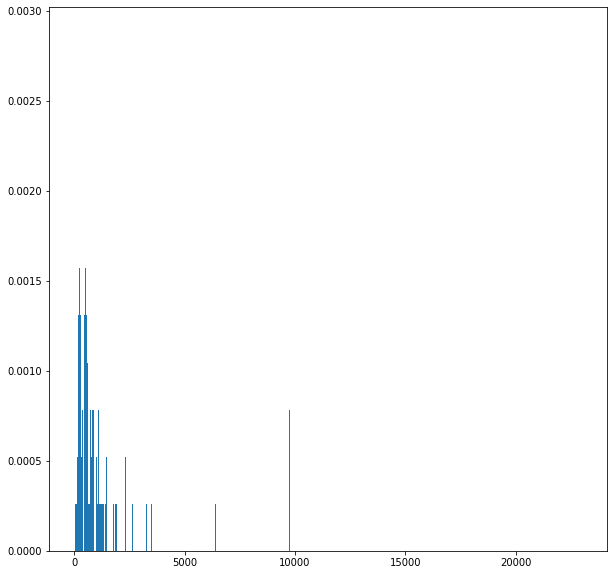

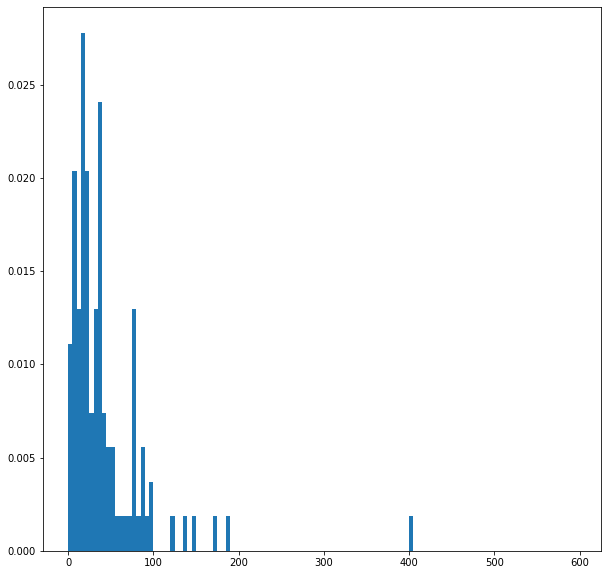

In [118]:
##Let's get the prices for a particular category and all the entries whose cosine similarity is higher than a threshold
def get_price_distribution(ix, th):
    print("Item:", unique_sentences[ix])
    print("Number of unique entries in the dataset:", len(X[np.where(indices == ix)]))
    print("Number of entries with cosine similarity:", len(X_sent[np.where(cosine_similarities[ix] >= th)]))
    print("Similar items based on embeddings:", np.unique(X_sent[np.where(cosine_similarities[ix] >= th)]))
    prices_items = y[np.where(cosine_similarities[ix] >= th)]
    print("Average prices:", np.average(prices_items))
    print("Std prices:", np.std(prices_items))
    print()
    return prices_items

pr_items = get_price_distribution(0, 0.9)
plt.figure(figsize = (10,10))
_ = plt.hist(pr_items, density = True, bins = np.arange(0, np.max(pr_items), 5))

pr_items = get_price_distribution(100, 0.9)
plt.figure(figsize = (10,10))
_ = plt.hist(pr_items, density = True, bins = np.arange(0, np.max(pr_items), 5))

pr_items = get_price_distribution(200, 0.9)
plt.figure(figsize = (10,10))
_ = plt.hist(pr_items, density = True, bins = np.arange(0, np.max(pr_items), 5))

**The price distribution is pretty wide, and sometimes present very far outliers that can alter the estimation of the price. Exploiting the description similarity helps increasing the number of products that are considered "close", but that does not help the price estimation. Out of curiosity, let's see what a slightly more sophisticated learning algorithm can produce**

In [49]:
from sklearn.model_selection import cross_validate
from sklearn import tree

clf = tree.DecisionTreeRegressor()
scores = cross_validate(clf, X, y, cv = 5, scoring = 'neg_root_mean_squared_error', return_train_score = True, return_estimator = True, verbose = 5, n_jobs = 4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   40.8s remaining:  1.0min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   58.1s finished


In [114]:
model = scores['estimator'][0]
y_pred_tree = model.predict(X)
y_val_pred_tree = model.predict(X_val)

print("Decision tree-based model, for training and validation set")
print(rmse_validation(y_pred_tree, y))
print(rmse_validation(y_val_pred_tree, y_val))

Decision tree-based model, for training and validation set
No entries for 0 items
RMSE: 3397.6898685081924

None
No entries for 0 items
RMSE: 3167.0841975347425

None


**Performance are slightly better on the training set, but still not usable in practice. We could think of using more complex methods (some sequence models based on the embeddings), but given that common-sense approaches do not bring us close enough to the solution of the problem, I highly doubt more complex ones would really work better.**

**As a possible way to use the embeddings, we could think of creating an outlier detector that would alert when a certain price for a given category is outside of a typical range. Instead of directly predicting a price (which seems hard now given the above results and analysis), we could try to build a model to detect when the paid price is not "fair". Clearly, we do not have the ground truth to really validate this approach (we do not know if an entry price was actually an outlier), but this could be useful nonetheless**

In [162]:
from sklearn.ensemble import IsolationForest

##We want to include all the features to make sure the price is included in the discriminative process.
isolation_forest = IsolationForest(n_estimators = 100, max_samples = 2048, max_features = 301, random_state = 11, n_jobs = -1, verbose = 1)
##Here we include the price because we want to use it as a discrminative factor when deciding whether an entry is an outlier or not
out_detector = isolation_forest.fit(np.append(X, y, axis = 1))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.1min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.1min finished


In [163]:
##We get the outliers for both training and validation set
outlier_train = out_detector.predict(np.append(X, y, axis = 1)) == -1
outlier_val = out_detector.predict(np.append(X_val, y_val, axis = 1)) == -1

In [164]:
print("Fraction of outliers in training set:", len(np.where(outlier_train == True)[0])/len(X))
print("Fraction of outliers in validation set:", len(np.where(outlier_val == True)[0])/len(X_val))

Fraction of outliers in training set: 0.04038776685268846
Fraction of outliers in validation set: 0.0407593801385221


**We obtain around 4% of outliers from the model. While this value is not unreasonable, it could be considered too high for the dataset under consideration (we are still talking about a controlled environment where the PA is monitored in the purchase behavior - intuitively, I would say that a value around 0.5% could be considered realistic). Let's give a look at the samples identified as outliers**

In [134]:
def find_outlier_sentence(sent):
    for i in range(len(unique_sentences)):
        if unique_sentences[i] == sent:
            return i
    ##This cannot happen, the sentence has to be present
    assert(False)

Sentence, num outliers, num inliers: ['acqua', 'idrogeno', 'ossigenata', 'perossido'] 2 34
Sentence, num outliers, num inliers: ['alcol', 'alcool', 'etilico'] 27 1
Sentence, num outliers, num inliers: ['antisettici', 'clorexidina', 'disinfettanti', 'gluconato'] 3 1
Sentence, num outliers, num inliers: ['banco', 'centrifughe'] 20 36
Sentence, num outliers, num inliers: ['connessioni', 'telefoniche'] 25 48
Sentence, num outliers, num inliers: ['copertine', 'rilegatura'] 119 293
Sentence, num outliers, num inliers: ['correttori'] 9 1051
Sentence, num outliers, num inliers: ['inchiostro', 'nastri'] 99 112
Sentence, num outliers, num inliers: ['mouse', 'tappetini'] 79 135
Sentence, num outliers, num inliers: ['sagome'] 3 26


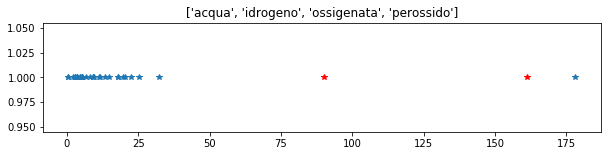

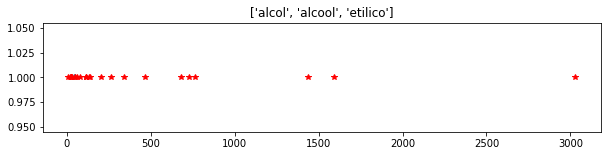

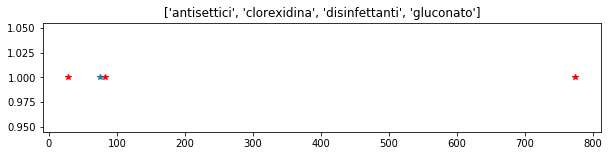

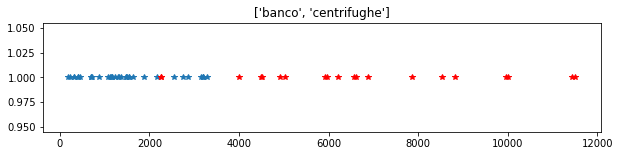

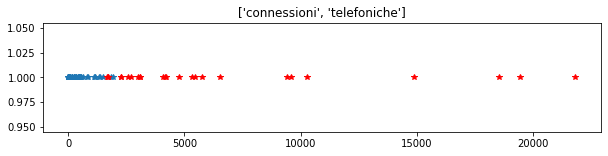

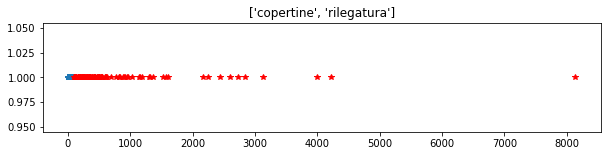

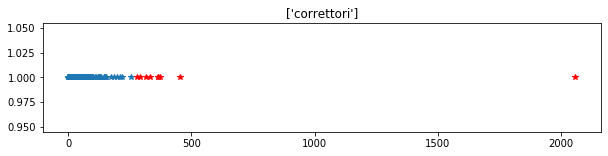

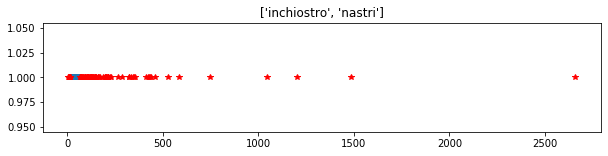

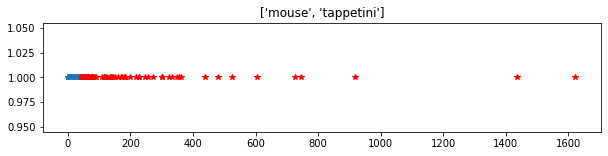

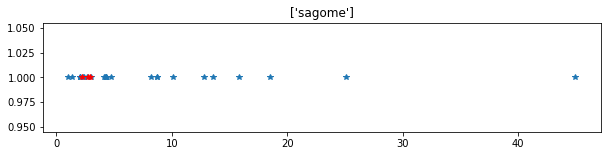

In [166]:
unique_sentences_outlier = np.unique(X_sent[outlier_train])

for sent in unique_sentences_outlier:
    outlier_sentence_index = find_outlier_sentence(sent)
    ##We consider all the entries that are outliers and whose cosine similarity is higher than a threshold with respect to the current entry
    y_out = y[np.where(np.logical_and(cosine_similarities[outlier_sentence_index] > 0.9, outlier_train == True))]
    y_in = y[np.where(np.logical_and(cosine_similarities[outlier_sentence_index] > 0.9, outlier_train == False))]
    ##Some categories are considered entirely as outliers
    if (len(y_in) > 0):
        print("Sentence, num outliers, num inliers:", sent, len(y_out), len(y_in))
        plt.figure(figsize = (10,2))
        plt.plot(y_in, len(y_in) * [1], '*')
        plt.plot(y_out, len(y_out) * [1], '*', color = 'red')
        _ = plt.title(str(sent))

**As shown in the results above, also the outlier detection based on the word embedding provides somewhat unclear results. Let's try to summarize some conclusions in the following**

**The goal we setup at the beginning of this excercise was to use the product description, transformed into an embedding vector, as a feature to predict the unit price of a certain order performed by a PA. I believe the assumption was reasonable, but the results do not confirm that, with the current dataset we have, it is possible to perform such a prediction. We identify the following lessons learned during this excercise:**

**1. For the price forecast approach**
* **Given the same good or service category, there is a pretty big variety of prices (sometimes in the order of thousands of euros). A possible explanation is that for some entries, the products are bought singularly, while for some other entries (even in the same category), some products are bought in bulk (e.g., 1000 mouse). This was potentially identifiable at the beginning of the analysis, but the rationale was that the embedding would have helped "averaging" out this wide price distribution, and that specific categories would have not presented such a variability;**
* **Given the large price distribution of the different categories, combining different ones together using the word embedding did not help much, because the combination of the two would still result in a very wide price distribution. For categories of items with less entries, there were not enough "close" categories that could help in creating a better prediction. Essentially, the clusters of categories were too much separated among each other, especially for less frequent items (which was the situation where the embedding would have been most useful);**
* **It is possible that with more fine-grained descriptions of the items and a better identification of the actual quantity of items in a specific order, the proposed approach could work more effectively and in line with the assumption that drove its initial development;**
* **Retrospectively, I think that detecting the outliers first could have been an interesting avenue for the approach (more on this below);**

**2. For the outlier detection approach**
* **Doing outlier detection using the embedding makes sense. The challenge is that we are trying to use the word embeddings AND the associated price to drive this detection. In this current implementation, we simply combined the word embeddings and the price together as features. This actually resulted in several categories in being detected as outliers alltogether, probably because the word embeddings features dominates over the price, when everything is combined together;**
* **A simpler approach could have been creating an outlier detection model per cluster (if based on the word embeddings) or per category (if we are simply using the category description). Something as simple as an interquartile range approach could have helped in removing outliers - per class;**
* **The combination of this second approach for outlier detection together with the price forecast approach, might provide better results that what reported in the previous analysis.**